In [30]:
!nvidia-smi

Thu Sep 19 16:11:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8               5W / 185W |    853MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Washington, D.C. 
"""

# Imports (many are imported in '__functions.py')

# Custom functions (__functions.py)
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Local imports
import sys, time, glob, gc
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box
from os.path import join

import warnings
warnings.filterwarnings("ignore")

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan' # cyverse

print("Successfully imported all packages and functions !")

Projected CRS: EPSG:32618
Successfully imported all packages!


In [3]:
# Prep the training data

In [4]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
gdf_path = join(homedir,'opp-data/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [5]:
ref.class_code.value_counts()

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64

In [6]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [7]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=10, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
CS    7830
ME    7830
SL    7830
UR    1279
WS    1152
TL     924
SH     783
Name: count, dtype: int64

In [8]:
# Split the train/test data
train_df, val_df, test_df = split_training_data(ref_bal, ts=0.4, vs=0.2)

# Print the class distribution in training and validation sets to verify stratification
print("Train class distribution:\n", train_df['code'].value_counts())
print("Validation class distribution:\n", val_df['code'].value_counts())
print("Test class distribution:\n", test_df['code'].value_counts())

Train class distribution:
 code
0    4698
1    4698
2    4698
3     767
5     691
4     554
6     469
Name: count, dtype: int64
Validation class distribution:
 code
0    2505
1    2505
2    2505
3     409
5     368
4     296
6     251
Name: count, dtype: int64
Test class distribution:
 code
0    627
1    627
2    627
3    103
5     93
4     74
6     63
Name: count, dtype: int64


In [9]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (8223, 6714)
bands: 6
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Array: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
[331255332 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [ ]:
# Set up the Resnet-18 model

In [10]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.8, 'patience': 3}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.8, 'patience': 3}


In [11]:
# Set up the Resnet-18 model

# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

# Grab the number of classes
n_classes = ref_bal.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.')

# Define the Resnet-18 model (in_channels = number of bands in the image)
model = resnet18(n_classes, in_channels=n_bands, pretrained=False)

# Make model parallel and on GPU
if torch.cuda.device_count() >= 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model.to(device)
else:
    model = nn.DataParallel(model)
    print('Made cpu parallel')

# optimizer, learning rate scheduler, loss criterion, scaler (gradient)
optimizer = optim.SGD(
    model.parameters(), 
    lr=params['learning_rate'], 
    momentum=params['momentum'], 
    weight_decay=params['weight_decay']
)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=params['patience'], 
    verbose=False, 
    min_lr=1e-6
)
scaler = torch.cuda.amp.GradScaler()  # initialize scaler for mixed precision

print('Ready to load data !')

Using cuda for model dev ...
There are 7 roof type classes.
Using  1 GPUs!
Ready to load data !


In [13]:
# Load the image data as a Dataset
# Uses the opimum window size calculated earlier

imdir = stack_da_fp
bs = params['batch_size']
window_size = params['window_size']

# Create the training samples
train_ds = RoofImageDatasetPlanet(train_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
train_loader = DataLoader(train_ds, batch_size=bs, num_workers=0, shuffle=True, pin_memory=True) 

# Create the validation samples
val_ds = RoofImageDatasetPlanet(val_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
val_loader = DataLoader(val_ds, batch_size=bs, num_workers=0, shuffle=False, pin_memory=True)

# Create the test samples
test_ds = RoofImageDatasetPlanet(test_df[['geometry', 'code']], imdir, n_bands=n_bands, img_dim=window_size)
test_loader = DataLoader(test_ds, batch_size=bs, num_workers=0, shuffle=False, pin_memory=True)

print("Training and validation data loaded!")

Training and validation data loaded!


In [14]:
# Number of samples in each class
val_counts = list(train_df['code'].value_counts())
total_samples = sum(val_counts) # total number of samples
print(f'Total samples: {total_samples};\nValue counts: {val_counts}')

# Calculate class weights
class_weights = [total_samples / count for count in val_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

class_weights_norm = class_weights / class_weights.sum()
print(f"Normalized class weights: {class_weights_norm}")

# Updated loss function with weights
criterion = nn.CrossEntropyLoss(weight=class_weights_norm).to(device)

Total samples: 16575;
Value counts: [4698, 4698, 4698, 767, 691, 554, 469]
Class weights: tensor([ 3.5281,  3.5281,  3.5281, 21.6102, 23.9870, 29.9188, 35.3412],
       device='cuda:0')
Normalized class weights: tensor([0.0291, 0.0291, 0.0291, 0.1779, 0.1975, 0.2464, 0.2910],
       device='cuda:0')


In [15]:
gc.collect()

169

In [16]:
t0 = time.time()

print_freq = int(len(train_loader) // 4) # quarterly print statements

# Initialize lists to track the losses for each epoch
train_losses = [] # stores epoch train losses
val_losses = [] # stores epoch validation losses
batch_train_losses= [] # all batch train losses
batch_val_losses = [] # all batch val losses

num_epochs = 22 # adjust as needed
for epoch in range(1, num_epochs):
    t00 = time.time() # epoch start time

    # The current learning rate:
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch}]. Current learning rate: {current_lr}")

    # Training loop
    model.train()

    batch_train_losses = [] # to store the loss/batch
    
    for idx, batch in enumerate(train_loader):
        # Ensure a good batch
        batch = make_good_batch(batch)
        
        # Extract samples (image chunk, target label)
        image, target = batch['image'].to(device), batch['code'].to(device)

        optimizer.zero_grad() # reset the gradient

        # Use mixed precision
        with torch.cuda.amp.autocast():
            output = model(image.float())
            loss = criterion(output, target.long())

        scaler.scale(loss).backward()  # Mixed precision backward pass
        scaler.step(optimizer)  # Optimizer step
        scaler.update()

        # Print the train progress % and current loss
        if idx % print_freq == 0:
            print(f'\ttrain progress: [{idx * len(image)}/{len(train_loader.dataset)}] ({(100. * idx / len(train_loader)):.2f})%')
            print(f'\tbatch train loss: {loss.item():.4f};\tcumulative batch: {len(train_loader) * epoch + idx}')
        
        batch_train_losses.append((idx, loss.item())) # append to batch losses list

        del image, target, batch, output, loss
                
    # average loss for the epoch (across batches)
    train_loss = np.array(batch_train_losses)[:,1].mean()
    train_losses.append(train_loss)
    
    # validation loss
    model.eval()
    
    val_loss = 0
    correct = 0
    all_labs = []
    all_preds = []
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            # Ensure a good batch
            batch = make_good_batch(batch) 
            
            # Extract samples
            image, target = batch['image'].to(device), batch['code'].to(device)
            output = model(image.float())

            # Get validation loss and predictions
            val_loss += criterion(output, target).item()
            predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct
            
            # Store the labels
            all_labs.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            del image, target, batch, output
            
        val_loss /= len(val_loader.dataset)/val_loader.batch_size
        val_losses.append(val_loss)
    
    print(f"\nEpoch [{epoch}] completed.")
    print(f'\ttrain loss: {train_loss}; validation loss = {val_loss:.4f}')

    acc = 100. * correct / len(val_loader.dataset)
    f1 = f1_score(all_labs, all_preds, average="weighted")
    print(f'\tAccuracy (validation): [{correct}/{len(val_loader.dataset)}] ({acc:.4f})%;\n\tF1-score (validation): {f1:.4f}')

    # Adjust the learning rate based on the validation loss
    lr_scheduler.step(val_loss)
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")
     
    t1 = (time.time() - t00) / 60
    print(f"Time to complete epoch [{epoch}]: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")
    
    gc.collect() # do a garbage cleanup
    torch.cuda.empty_cache() # empty the GPU
    
t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Epoch [1]. Current learning rate: 0.01
	train progress: [0/16575] (0.00)%
	batch train loss: 2.0596;	cumulative batch: 259
	train progress: [4096/16575] (24.71)%
	batch train loss: 1.6667;	cumulative batch: 323
	train progress: [8192/16575] (49.42)%
	batch train loss: 1.6543;	cumulative batch: 387
	train progress: [12288/16575] (74.13)%
	batch train loss: 1.3044;	cumulative batch: 451
	train progress: [16384/16575] (98.84)%
	batch train loss: 1.4265;	cumulative batch: 515

Epoch [1] completed.
	train loss: 1.6320627246584212; validation loss = 1.5201
	Accuracy (validation): [3273/8839] (37.0291)%;
	F1-score (validation): 0.3982
Time to complete epoch [1]: 6.40 minutes.

~~~~~~~~~~

Epoch [2]. Current learning rate: 0.01
	train progress: [0/16575] (0.00)%
	batch train loss: 1.7316;	cumulative batch: 518
	train progress: [4096/16575] (24.71)%
	batch train loss: 1.2661;	cumulative batch: 582
	train progress: [8192/16575] (49.42)%
	batch train loss: 1.5783;	cumulative batch: 646
	train pro

In [17]:
results_dir = os.path.join(homedir,'results/')

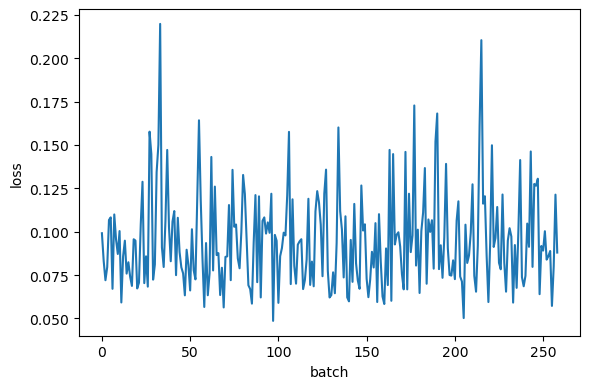

In [18]:
# Plot the batch losses
plt.figure(figsize=(6, 4))

plt.plot(np.array(batch_train_losses)[:,1])

plt.xlabel('batch')
plt.ylabel('loss')
plt.tight_layout()

out_png = os.path.join(homedir,'results/dc_batch_train_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

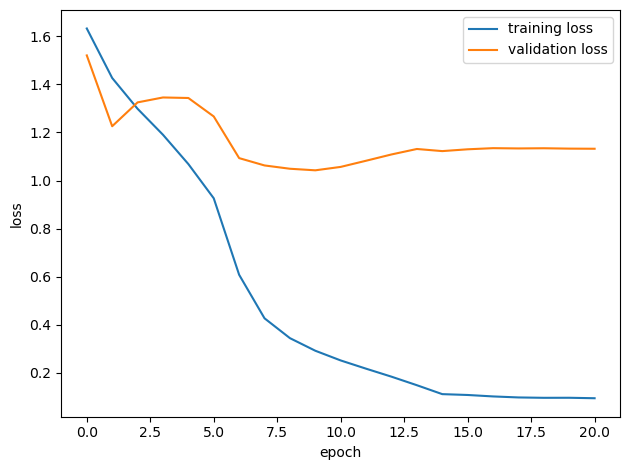

In [19]:
# Epoch training loss
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.legend()

out_png = os.path.join(homedir,'results/dc_epoch_trainval_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Check model complexity

In [20]:
train_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of traininable model parameters: {train_model_params}")

Number of traininable model parameters: 11189511


In [ ]:
# Save the model elements

In [21]:
os.getcwd()

'/home/jovyan/opp-rooftop-mapping/code'

In [22]:
# Save the model
save_res = True

if save_res:
    # directory
    save_dir = os.path.join(homedir,'results/')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    step = len(train_losses)
    model_nm = f'ep{num_epochs}_step{step}_b{bs}'
    model_path = f'dc_planet_ms_{model_nm}.pt'
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'step': step,
        }, str(model_path))
    save(model_path)

    # save loss, etc

    # batch loss
    np.savetxt(os.path.join(save_dir,f'dc_batch_train_losses_{model_nm}.txt'), np.array(batch_train_losses))
    np.savetxt(os.path.join(save_dir,f'dc_batch_val_losses_{model_nm}.txt'), np.array(batch_val_losses))
    
    # epoch loss
    np.savetxt(os.path.join(save_dir,f'dc_train_losses_{model_nm}.txt'), np.array(train_losses))
    np.savetxt(os.path.join(save_dir,f'dc_val_losses_{model_nm}.txt'), np.array(val_losses))

print("Saved model and losses.")

Saved model and losses.


In [ ]:
# Make predictions on the holdout data

In [23]:
def get_prediction(m, s):
    s = s.to(device)  # Ensure the sample is moved to the correct device
    res = m(s)
    return res

true_labels = []
pred_labels = []

model.eval()  # Set model to evaluation mode

for idx, sample in enumerate(test_ds):
    try:
        if sample['code'] != 255:
            # Append true labels
            true_labels.append(sample['code'].item())  # Convert tensor to Python scalar
                        
            # Get prediction and append
            pred = get_prediction(model, sample['image'][None, ...].float().to(device))  # Ensure tensor is float and on the correct device
            pred_labels.append(pred.argmax().item())  # Convert tensor to Python scalar
            
        else:
            print(f'sample {idx} of {len(test_ds)} had class label 255, skipping...')
        
        if idx % 100 == 0:
            time.sleep(0.3)
            gc.collect()
            print(f'Processed {idx} samples...')
        
    except Exception as e:
        print(f'Error at sample {idx}: {e}, continuing...')

Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Processed 2000 samples...
Processed 2100 samples...
Processed 2200 samples...


In [24]:
# Ensure 'class_code' is of categorical dtype
test_df['code'] = test_df['code'].astype('category')
# Create a dictionary mapping class_code to code
code_mapping = dict(zip(test_df['code'], test_df['class_code']))
desc_mapping = dict(zip(test_df['class_code'], test_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 5: 'WS', 4: 'TL', 6: 'SH'}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'WS': 'Wood shake/shingle', 'TL': 'Tile', 'SH': 'Shingle'}


In [25]:
# Save to a dataframe
preds_df = pd.DataFrame({
    'true_code': true_labels,
    'pred_code': pred_labels
})

# Add a column for the true class_code using the code_mapping dictionary
preds_df['true_class'] = preds_df['true_code'].map(code_mapping)
preds_df['pred_class'] = preds_df['pred_code'].map(code_mapping)

# Save the DataFrame as a CSV file if needed
preds_df.to_csv(os.path.join(homedir,'results/dc_predictions_holdout.csv'), index=False)

In [26]:
true_class_labels = [code_mapping[code] for code in true_labels]
pred_class_labels = [code_mapping[code] for code in pred_labels]
class_codes = list(code_mapping.values())

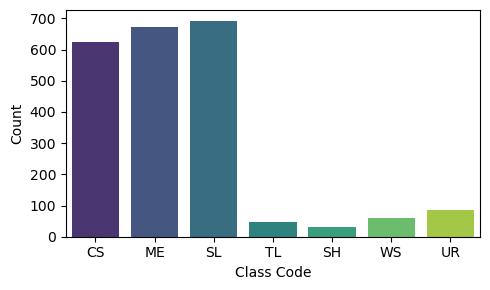

In [27]:
pred_class_labels = [code_mapping[code] for code in pred_labels]

plt.figure(figsize=(5, 3))
sns.countplot(x=pred_class_labels, palette='viridis')
plt.xlabel('Class Code')
plt.ylabel('Count')
plt.tight_layout()

out_png = os.path.join(homedir,'results/dc_cnn_pred_labels.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Generate the classification report

In [34]:
print(true_class_labels[0:5])
print(pred_class_labels[0:5])
print(class_codes)

['CS', 'CS', 'CS', 'CS', 'CS']
['CS', 'ME', 'ME', 'SL', 'CS']
['CS', 'ME', 'SL', 'UR', 'WS', 'TL', 'SH']


In [35]:
# Generate the classification report
cr_df = pd.DataFrame(classification_report(
    true_class_labels, pred_class_labels,
    output_dict=True)).transpose()
cr_df['class_code'] = cr_df.index
# Save the report as a CSV
cr_df.to_csv(os.path.join(save_dir, 'dc_resnet18_classification_report.csv'))
print(cr_df)

              precision    recall  f1-score     support    class_code
CS             0.644800  0.642743  0.643770   627.00000            CS
ME             0.759287  0.814992  0.786154   627.00000            ME
SH             0.333333  0.158730  0.215054    63.00000            SH
SL             0.619942  0.684211  0.650493   627.00000            SL
TL             0.586957  0.364865  0.450000    74.00000            TL
UR             0.528736  0.446602  0.484211   103.00000            UR
WS             0.459016  0.301075  0.363636    93.00000            WS
accuracy       0.656730  0.656730  0.656730     0.65673      accuracy
macro avg      0.561724  0.487603  0.513331  2214.00000     macro avg
weighted avg   0.646183  0.656730  0.648131  2214.00000  weighted avg


In [ ]:
# Generate the confusion matrix

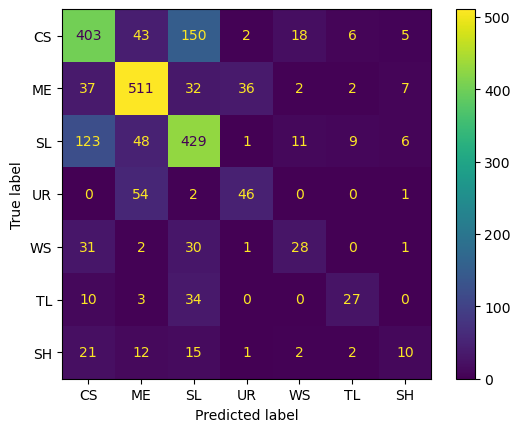

In [29]:
# Get the correct class names
class_names = list(code_mapping.values())
  
# Plot the confusion matrix
cm = confusion_matrix(true_class_labels, pred_class_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

# Save it
out_png = os.path.join(homedir,'results/dc_cnn_confusion_matrix.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  